**Section 1. Logistic Regression from Scratch.**

We will build a logistic regression model from scratch step by step to predict whether the harvest will exceed 80 apples (the task is similar to the lecture, but for classification).

Let's recall the basic formulas for logistic regression.

### Hypothesis Function - Calculating Predictions in Logistic Regression:

$$
\hat{y} = \sigma(x W^T + b) = \frac{1}{1 + e^{-(x W^T + b)}}
$$

Where:
- $ \hat{y} $ — is the probability of the "positive" class.
- $ x $ — is a vector (or matrix for a dataset) of input data.
- $ W $ — is a vector (or matrix) of model weights.
- $ b $ — is the bias.
- $ \sigma(z) $ — is the sigmoid activation function.

### How the Sigmoid Function is Calculated:

The sigmoid function $ \sigma(z) $ is given by:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

This function transforms any real value $ z $ into the interval from 0 to 1, allowing the output to be interpreted as a probability for logistic regression.

### Loss Function Formula for Logistic Regression (Binary Cross-Entropy):

The cross-entropy loss function evaluates how well the model predicts classes by comparing the predicted probabilities $ \hat{y} $ with the true labels $ y $. The formula is as follows:

$$
L(y, \hat{y}) = - \left[ y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right]
$$

Where:
- $ y $ — is the true value (class label, 0 or 1).
- $ \hat{y} $ — is the predicted value (probability).

1.
Here is the code to initialize the dataset in numpy format. Convert `inputs`, `targets` to `torch` tensors. Print the result to the screen.

In [ ]:
import torch
import numpy as np

In [ ]:
# Input data (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]], dtype='float32')

# Targets (apples > 80)
targets = np.array([[0],
                    [1],
                    [1],
                    [0],
                    [1]], dtype='float32')

inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
print(inputs)
print(targets)

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.]])


2. Initialize the weights `w`, `b` for the logistic regression model in the required shape using random values from a normal distribution based on the dimensions of the data. I'm leaving the code here to fix the `random_seed`.

In [381]:
inputs.shape, targets.shape

(torch.Size([5, 3]), torch.Size([5, 1]))

In [382]:
inputs.shape

torch.Size([5, 3])

In [383]:
# x * W + b -> [5, 3] * [3, 1] + [1] -> [5, 1]
torch.random.manual_seed(1)
w = torch.randn(3, 1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
print(f'W: {w}')
print(f'b: {b}')

W: tensor([[0.6614],
        [0.2669],
        [0.0617]], requires_grad=True)
b: tensor([0.6213], requires_grad=True)


# Conclusions 2
- The dimension of the input matrix **X** = (5,3), and we need to obtain (5, 1) at the output - one column that has 5 rows corresponding to each input element.
- Thus, the matrix **w** needs to be (3,1) to allow for multiplication without issues. Meanwhile, **b** will be just 1 element.

3. Write a function `model` that will compute the hypothesis function in logistic regression and allow making predictions based on the input data string and the coefficients in the variables `w`, `b`.

  **Important point**, the function `model` performs calculations on `torch.tensors`, so for mathematical computations we use the `torch` functionality, for example:
  - calculating $e^x$: `torch.exp(x)`
  - calculating $log(x)$: `torch.log(x)`
  - calculating the mean of vector `x`: `torch.mean(x)`

  Use the `model` function to compute predictions with the current values of `w`, `b`. Print the results of the calculations on the screen.

  Analyze the predictions. Do they raise any suspicions for you? And if they do, what could be the reason for that?

In [ ]:
def model(x, w, b):
    # Calculate the sigmoid activation
    sigmoid = 1 / (1 + torch.exp(-(x @ w + b)))
    return sigmoid

In [385]:
preds = model(inputs, w, b) 
preds

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<MulBackward0>)

In [386]:
preds, targets

(tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]], grad_fn=<MulBackward0>),
 tensor([[0.],
         [1.],
         [1.],
         [0.],
         [1.]]))

# Conclusions 3
- After calculating the sigmoid, all elements have a probability of 1. This raises a question, as the sigmoid should return a probability between 0 and 1.
- It seems that at this stage the curvature of the sigmoid is very suboptimal; it may be too shifted to the side or have a very steep slope (looking like a unit step function with an instantaneous transition from 0 to 1).

4. Write a function `binary_cross_entropy` that takes as input the model predictions `predicted_probs` and the true labels in the data `true_labels` and calculates the loss value using the binary cross-entropy formula for each instance and returns the average loss across the entire dataset.  
Use the `binary_cross_entropy` function to calculate the loss for the current model predictions.

In [ ]:
def binary_cross_entropy(y_pred, y_true):
    y_pred = y_pred.clamp(min=1e-7, max=1-1e-7) # avoid log(0)
    L = y_true*torch.log(y_pred) + (1 - y_true)*torch.log(1 - y_pred)
    return torch.mean(-L)

In [388]:
loss = binary_cross_entropy(preds, targets)
loss

tensor(6.3770, grad_fn=<MeanBackward0>)

5. Perform backpropagation and output the gradients for the parameters `w`, `b`. Analyze their values. What do you think is the reason for their specific values?

In [389]:
loss.backward()  
w.grad, b.grad  

(tensor([[0.],
         [0.],
         [0.]]),
 tensor([0.]))

# Conclusions 5
- For the loss function, we had to add additional conditions `y_pred.clamp(min=1e-7, max=1-1e-7)` to make the calculations possible, otherwise, it would attempt to find the logarithm of 0.
- The fact that we obtained zero gradients (or they are not zero but very small) may somehow be related to the properties of the logarithm, where the argument approaching 0 leads to the logarithm value approaching negative infinity. Since logistic regression is sensitive to the scales of the data, this may affect the difficulty in calculating the gradients.

**What happened?**

In this task, when we initialized the values with random values from a normal distribution, those values were not very good starting points and led to the gradients becoming very small or even equal to zero (this leads to the gradients "vanishing"), and accordingly, when updating the weights, we would have nothing changing. This is called `gradient vanishing`. This occurs due to **saturation of the sigmoid activation function.**

In our task, we use the sigmoid activation function, which has the following form:

   $$
   \sigma(z) = \frac{1}{1 + e^{-z}}
   $$

When the value of $z$ is very large or very small, the sigmoid function starts to "saturate." This means that for large positive $z$, the sigmoid approaches 1, and for large negative $z$, it approaches 0. In these ranges, the gradients begin to decrease rapidly and approach zero (since the gradient is the derivative, the derivative over an interval of the function where it is parallel to the X-axis is equal to 0), making weight updates impossible.

![](https://editor.analyticsvidhya.com/uploads/27889vaegp.png)

In logistic regression, $ z = x \cdot w + b $. If the weights $w, b$ are large, the value of $z$ will also be large, and the sigmoid will enter the saturated region where the gradients are very small.

This is exactly what happened in our task, where large random weight values caused the saturation of the sigmoid function. This, in turn, leads to the model updating the weights very slowly or not at all during backpropagation. This is called the **gradient vanishing problem**.

**What to do?**
Initialize the weights with small values around zero. For example, we can simply divide the existing initialization weights by 1000. Another method of weight initialization can also be used - information about this can be found [here](https://www.geeksforgeeks.org/initialize-weights-in-pytorch/).

How to do this - I will show below. **Run the code and recalculate the predictions, loss, and output the gradients.**

And I will explain why we can't just do

```
w = torch.randn(1, 3, requires_grad=True)/1000
b = torch.randn(1, requires_grad=True)/1000
```

We need the weight tensors to be leaf tensors.

1. **What is a leaf tensor?**
A leaf tensor is a tensor that was created by the user directly and from which the computational graph starts. If such a tensor has `requires_grad=True`, PyTorch will track all operations performed on it to correctly compute gradients during training.

2. **Why do we use `w.data` instead of regular operations?**
If we simply performed operations like `(w - 0.5) / 100`, we would get a **new tensor** that would no longer be a leaf tensor, as these operations create a **new** tensor rather than modifying the existing one.

  However, to keep our weight tensor `w` and bias `b` as leaf tensors and maintain the ability to track gradients during training, we use the `.data` attribute. This attribute allows us to **perform in-place operations (directly on the existing tensor)** without changing the tensor object itself. Thus, the tensor remains a leaf tensor, and PyTorch can correctly compute its gradients.

3. **Why is it important to keep the tensor as a leaf?**
If the tensor is no longer a leaf (for example, due to operations that create new tensors), you will not be able to obtain gradients using `w.grad` or `b.grad` after calling `loss.backward()`. This can lead to the loss of the ability to update parameters during model training. In our case, we want the tensors `w` and `b` to accumulate gradients, so they must remain leaf tensors.

**Conclusion:**
We use `.data` to perform value-changing operations on weights and biases **in-place**, keeping them as leaf tensors that can accumulate gradients during training. This allows the backpropagation mechanism to work correctly and update the model weights.

5. Execute the code and recalculate the predictions, loss, and find the gradients, then display all these tensors on the screen.

In [390]:
torch.random.manual_seed(1)
w = torch.randn(3, 1, requires_grad=True)  # Leaf tensor w = torch.randn(1, 3, requires_grad=True) 
b = torch.randn(1, requires_grad=True)     # Leaf tensor

# in-place operations
w.data = w.data / 1000
b.data = b.data / 1000

In [391]:
w, b

(tensor([[6.6135e-04],
         [2.6692e-04],
         [6.1677e-05]], requires_grad=True),
 tensor([0.0006], requires_grad=True))

In [392]:
preds_2 = model(inputs, w, b)
print(preds_2)

loss_2 = binary_cross_entropy(preds_2, targets)
print(loss_2)

tensor([[0.5174],
        [0.5220],
        [0.5244],
        [0.5204],
        [0.5190]], grad_fn=<MulBackward0>)
tensor(0.6829, grad_fn=<MeanBackward0>)


In [393]:
loss_2.backward() 
w.grad, b.grad

(tensor([[ -5.4417],
         [-18.9853],
         [-10.0682]]),
 tensor([-0.0794]))

# Conclusions 5.
- After scaling the parameters, we were able to obtain predictions in probability values and now the gradients are calculated correctly.

6. Write a gradient descent algorithm that will train the model using the previously written functions and perform weight updates. The algorithm should include the following steps:

    1. Generate predictions
    2. Calculate losses
    3. Compute gradients of the loss function with respect to weights and biases
    4. Adjust weights by subtracting a small amount proportional to the gradient (`learning_rate` multiplied by the gradient)
    5. Reset gradients to zero

Perform gradient descent for 1000 epochs, compute the final predictions, and analyze whether they are accurate?

In [ ]:
def gradient(w, b, X, y, learning_rate = 0.001, epoch = 1000):
    for i in range (epoch):
        preds = model(X, w, b)
        loss = binary_cross_entropy(preds, y)
        loss.backward()
        with torch.no_grad():
            w -= w.grad * learning_rate
            b -= b.grad * learning_rate

            w.grad.zero_()
            b.grad.zero_()

        if (i % 100 == 0):   
            print(f'epoch {i}: loss = {loss}')  

    print(f'epoch {i}: loss = {loss}') # last epoch loss
    return w, b  

In [395]:
w_final, b_final = gradient(w, b, inputs, targets, learning_rate = 0.001, epoch = 1000)  # Final weights and bias after training

epoch 0: loss = 0.6829456686973572
epoch 100: loss = 0.19763095676898956
epoch 200: loss = 0.1621902883052826
epoch 300: loss = 0.13796372711658478
epoch 400: loss = 0.11963769048452377
epoch 500: loss = 0.10523238033056259
epoch 600: loss = 0.09364277869462967
epoch 700: loss = 0.08415229618549347
epoch 800: loss = 0.076265349984169
epoch 900: loss = 0.06962650269269943
epoch 999: loss = 0.06402741372585297


In [396]:
preds_final = model(inputs, w_final, b_final)
print(f'Output: \n{preds_final}\n')
preds_round = preds_final.round()
print(f'Rounded output: \n{preds_round}\n')
print(f'Target: \n{targets}\n')

accuracy = (preds_round == targets).float().mean()  
print(f'accuracy = {accuracy}')

Output: 
tensor([[1.6794e-01],
        [8.7485e-01],
        [9.9769e-01],
        [2.3414e-07],
        [9.9999e-01]], grad_fn=<MulBackward0>)

Rounded output: 
tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.]], grad_fn=<RoundBackward0>)

Target: 
tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.]])

accuracy = 1.0


# Conclusions 6
- After 1000 epochs, we managed to train an accurate classifier. All values were predicted correctly. The probability values for each record are quite unambiguous (close to 0 or 1), and there are no values around 0.5 when the classifier is "unsure" about the predictions.
- The loss function reached a value of 0.064, compared to 0.683 at the beginning. From the loss history, it is clear that the classifier made good progress in training with each epoch.

**Section 2. Creating logistic regression using the `torch.nn` functionality.**

Let's re-implement the same model using some built-in functions and classes from PyTorch.

We will have more data - so, let's define new arrays.

In [ ]:
# Input data (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70],
                   [73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70],
                   [73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]], dtype='float32')

# Targets (apples > 80)
targets = np.array([[0],
                    [1],
                    [1],
                    [0],
                    [1],
                    [0],
                    [1],
                    [1],
                    [0],
                    [1],
                    [0],
                    [1],
                    [1],
                    [0],
                    [1]], dtype='float32')

7. Load the input data and labels into PyTorch tensors and create a dataset that combines the input data with the labels using the `TensorDataset` class. Display the first 3 elements in the dataset.

In [398]:
import torch.nn as nn   
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
print(inputs.shape, targets.shape)

train_ds = TensorDataset(inputs, targets)
train_ds[0:3]

torch.Size([15, 3]) torch.Size([15, 1])


(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.]]),
 tensor([[0.],
         [1.],
         [1.]]))

8. Define a data loader with the class **DataLoader** for the prepared dataset `train_ds`, set the batch size to 5, and enable shuffling of the data for effective model training. Output the first element in the data loader.

In [399]:
batch_size = 5
torch.random.manual_seed(1)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)  # Create a data loader for the training dataset
next(iter(train_dl))  # Get the next batch from the data loader

[tensor([[ 69.,  96.,  70.],
         [ 91.,  88.,  64.],
         [ 69.,  96.,  70.],
         [ 87., 134.,  58.],
         [ 73.,  67.,  43.]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [0.]])]

9. Create a class `LogReg` for logistic regression, inheriting from the `torch.nn.Module` as shown in the lecture (in the part about FeedForward networks).

  Our model consists of a linear combination of input values and the application of the sigmoid function. Therefore, the neural network will consist of a linear layer `nn.Linear` and the use of the activation `nn.Sigmoid`. The created class should implement the `__init__` method for initializing the layers and the `forward` method for performing the forward pass of the model through the linear layer and the activation function.

  Create an instance of the `LogReg` class in the variable `model`.

In [400]:
class LogReg (nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 1)  # Linear layer with 3 input features and 1 output
        self.act = nn.Sigmoid()  # Sigmoid activation function

    def forward(self, x):
        x = self.linear(x)  # Pass input through the linear layer
        x = self.act(x)  # Apply the activation function
        return x  # Return the output

In [ ]:
model = LogReg()
print(model)

LogReg(
  (linear): Linear(in_features=3, out_features=1, bias=True)
  (act): Sigmoid()
)


10. Set the optimizer `Stochastic Gradient Descent` in the variable `opt` for training the logistic regression model. Also, define the loss function `binary_cross_entropy` from the `torch.nn.functional` module in the variable `loss` to calculate the model's losses. Calculate the losses for the current predictions and labels, and then output them. Draw a conclusion on whether the model has managed to learn.

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.functional.binary_cross_entropy

loss_init = loss_fn(model(inputs), targets) # first initialization of the model
loss_init

tensor(9.2144, grad_fn=<BinaryCrossEntropyBackward0>)

# Conclusions 10
- The obtained loss is 9.2144, but the model training has not yet occurred. We have only initialized the first parameters and ran the model with them. To train the model, we need to calculate the gradients in order to find the optimal model parameters.

11. Take the function from the lecture for training the model with tracking loss values and train the newly defined model for 1000 epochs. After that, display the graph of loss changes, final predictions, and target values.

In [403]:
def fit_return_loss(num_epochs, model, loss_fn, opt, train_dl):
    losses = []
    for epoch in range(num_epochs):
        total_loss = 0

        for xb, yb in train_dl:

            pred = model(xb)
            loss = loss_fn(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

            total_loss += loss.item()

        if (epoch % 100 == 0):   
            print(f'epoch {epoch}: loss = {loss}')     

        avg_loss = total_loss / len(train_dl)
        losses.append(avg_loss)

    print(f'epoch {epoch}: loss = {loss}') # loss of the last epoch
          
    return losses

In [404]:
loss_all = fit_return_loss(1000, model, loss_fn, opt, train_dl)  # Train the model for 1000 epochs and return the loss

epoch 0: loss = 1.9916292428970337
epoch 100: loss = 0.11025049537420273
epoch 200: loss = 0.08742950856685638
epoch 300: loss = 0.0842357724905014
epoch 400: loss = 0.05680143088102341
epoch 500: loss = 0.021527491509914398
epoch 600: loss = 0.06468236446380615
epoch 700: loss = 0.015324542298913002
epoch 800: loss = 0.03839382156729698
epoch 900: loss = 6.565875979495828e-18
epoch 999: loss = 0.03812045603990555


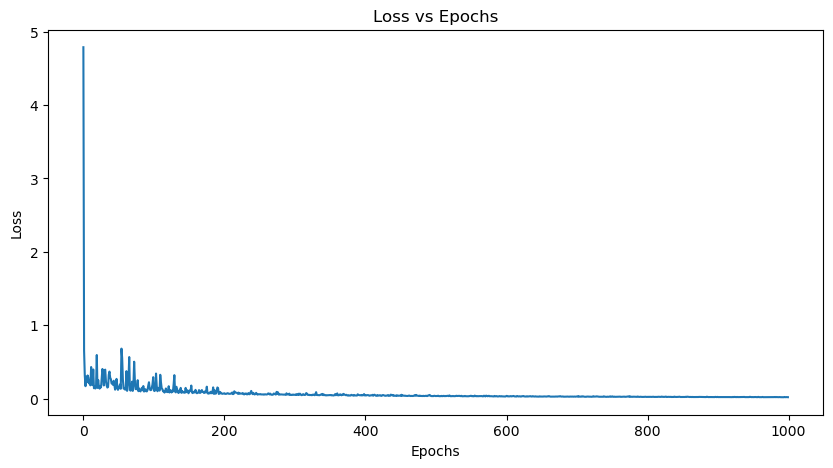

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(loss_all)
plt.title('Loss vs Epochs') 
plt.xlabel('Epochs')  
plt.ylabel('Loss')  

plt.show()

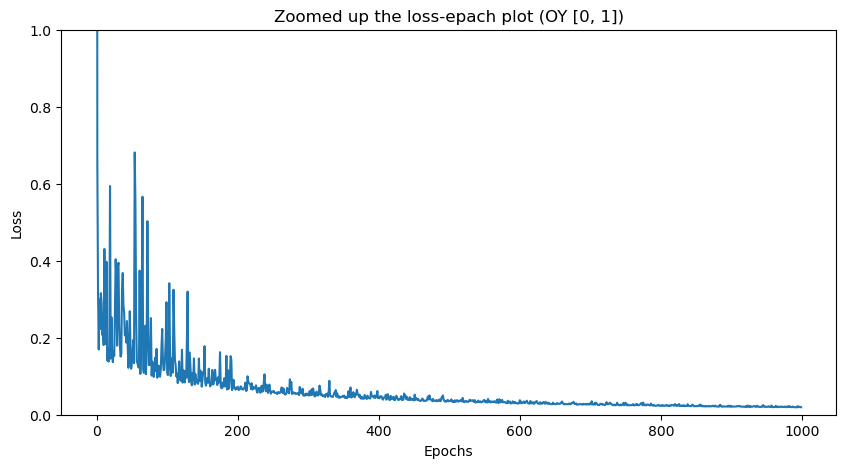

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(loss_all)
plt.title('Zoomed up the loss-epoch plot (OY [0, 1])')
plt.xlabel('Epochs') 
plt.ylabel('Loss')  
plt.ylim(0, 1) 
plt.show()  

In [406]:
preds = model(inputs)
accuracy = (preds > 0.5).int() == targets.int()
accuracy = accuracy.float().sum() / len(accuracy)
print(f'accuracy = {accuracy}')
(preds > 0.5).int(), targets  

accuracy = 1.0


(tensor([[0],
         [1],
         [1],
         [0],
         [1],
         [0],
         [1],
         [1],
         [0],
         [1],
         [0],
         [1],
         [1],
         [0],
         [1]], dtype=torch.int32),
 tensor([[0.],
         [1.],
         [1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [1.],
         [0.],
         [1.]]))

# Conclusions
- The predictions for the model were perfect, and it completely accurately predicts all the labels of the records.
- The loss graph also shows that the model quickly reduced the loss in the first few epochs. Then, until the 200th epoch, fluctuations were observed (due to the fact that we split the data into batches and the weights were updated each time for different parts of the dataset, which could introduce "noise"). After that, the model managed to stabilize with minimal fluctuations in the loss function. After a thousand epochs, a loss of 0.038 was achieved.